<a href="https://colab.research.google.com/github/Louis5228/Mechine-Learning/blob/main/309512014_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [399]:
import os
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
import cv2
from numpy.linalg import inv, pinv, linalg
drive.mount('/content/gdrive')

data = pd.read_csv("/content/gdrive/My Drive/Machine_Learning/HW2/dataset/data.csv")
data = np.array(data)
x = data[:, :1]
t = data[:, 1:]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#1. Sequential Bayesian Learning

In [400]:
M = 3
s = 0.6
N_list = [5, 10, 30, 80]
N_index = [0, 5, 10, 30, 80]
beta = 1
m0 = np.zeros((M,1))
s0_inv = math.pow(10,-6)*np.eye(M)

def sigmoid_f(a):
  return 1 / (1 + np.exp(-a))

def cal_phi(x):
  phi = np.empty([len(x),0])
  for j in range(M):
    mu = 2*j / M
    phi = np.hstack((phi, sigmoid_f((x - mu) / s)))
  return phi

def posterior_dist(m0, s0_inv, beta, phi, t):
  sN_inv = s0_inv + beta*np.dot(phi.T, phi)
  sN = inv(sN_inv)
  mN = np.dot(sN, (np.dot(s0_inv, m0) + beta*np.dot(phi.T, t)))
  return mN, sN

def ground_truth(x):
  gt = 1 + (3/(math.sqrt(2*math.pi)*0.5))*np.exp(-(x**2)/(2*0.5**2)) - (2/math.sqrt(2*math.pi))*np.exp(-((x-1)**2)/2)
  return gt

mN_l = []
sN_l = []
for i in range(1, len(N_index)):
  x_temp = x[N_index[i-1]:N_index[i]]
  t_temp = t[N_index[i-1]:N_index[i]]
  mN, sN = posterior_dist(m0, s0_inv, beta, cal_phi(x_temp), t_temp)
  mN_l.append(mN)
  sN_l.append(sN)
  # print("Data size:", N_index[i], "\nmean:\n", mN, "\nconvariance:\n", sN, "\n")

  m0 = mN
  s0_inv = inv(sN)

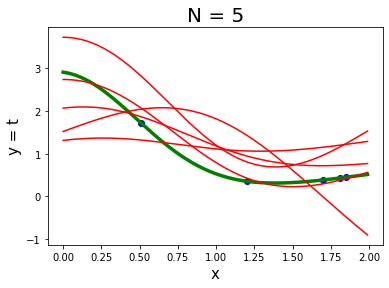

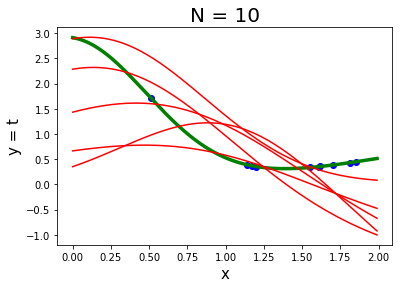

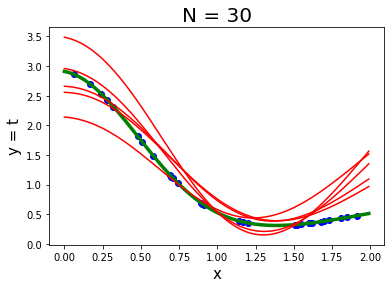

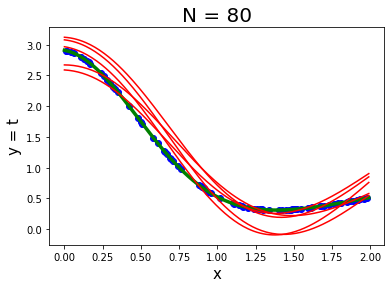

In [401]:
# 1.
curve_num = 5
sample_x = np.arange(0, 2, 0.01).reshape(200,1)

for i in range(len(N_list)):
  plt.title('N = ' + str(N_list[i]), fontsize = 20)
  plt.xlabel('x', fontsize = 15)
  plt.ylabel('y = t', fontsize = 15)
  plt.plot(sample_x, ground_truth(sample_x), color='g', linewidth=3.5)
  for j in range(N_list[i]):
    plt.scatter(x[j], t[j], color='b')
  for k in range(curve_num):
    w = np.random.multivariate_normal(mN_l[i].reshape(M), sN_l[i]).reshape(1, 3)
    y = np.dot(w, cal_phi(sample_x).T).reshape(200,1)
    plt.plot(sample_x, y, color='r')
  plt.show()

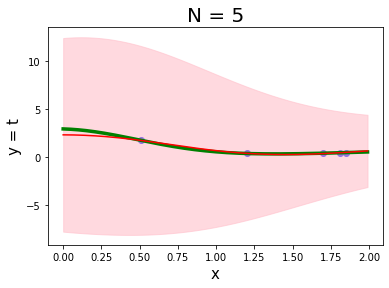

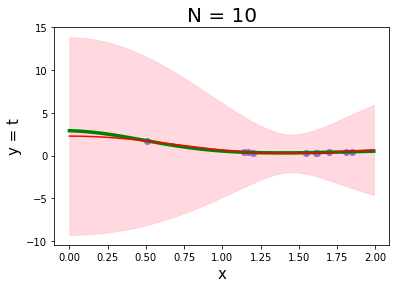

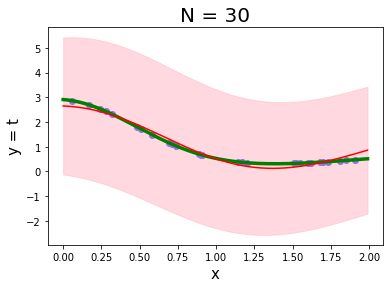

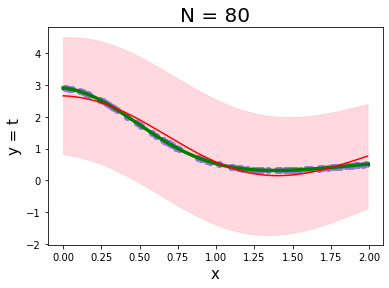

In [402]:
# 2.
def predictive_dist(x, mN, sN, beta):
  phi = cal_phi(x)
  mean = phi.dot(mN)
  variance = 1/beta + np.sum(phi.dot(sN).dot(phi.T), axis=1)
  std_D = np.sqrt(variance)
  return mean.reshape(len(x)), std_D

for i in range(len(N_list)):
  plt.plot(sample_x, ground_truth(sample_x), color='g', linewidth=3.5)
  for j in range(N_list[i]):
    plt.scatter(x[j], t[j], color='b')
  mean, std_D = predictive_dist(sample_x, mN_l[i], sN_l[i], beta)
  plt.title('N = ' + str(N_list[i]), fontsize = 20)
  plt.xlabel('x', fontsize = 15)
  plt.ylabel('y = t', fontsize = 15)
  plt.plot(sample_x, mean, color='r')
  plt.fill_between(sample_x.reshape(len(sample_x)), mean-std_D, mean+std_D, alpha=0.6, color='pink')
  plt.show()

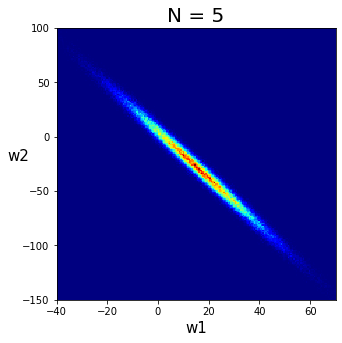

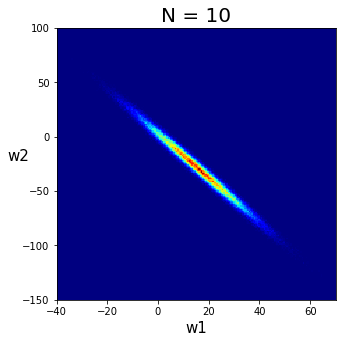

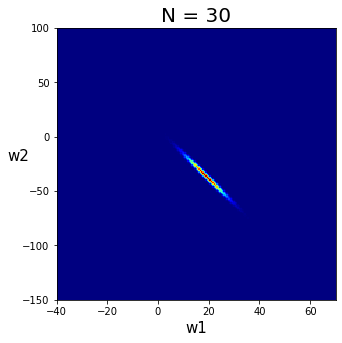

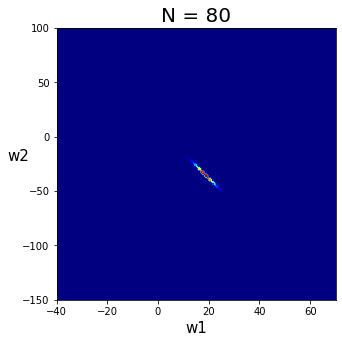

In [403]:
# 3.
sample_num = 100000
for i in range(len(N_list)):
  w = np.random.multivariate_normal(mN_l[i].reshape(M), sN_l[i], size=sample_num)
  w1 = w[:,0]
  w2 = w[:,1]
  plt.figure(figsize=(5,5))
  plt.hist2d(w1, w2, bins=200, cmap='jet', range=[[-40,70],[-150,100]])
  plt.title('N = ' + str(N_list[i]), fontsize = 20)
  plt.xlabel('w1', fontsize = 15)
  plt.ylabel('w2', rotation=0, fontsize = 15)
  plt.show()

#2. Logistic Regression

In [404]:
class_num = 5
img_num = 64
img_height = 28
img_width = 28
feature_num = img_height * img_width #28*28=784

train_x = np.zeros([1, feature_num])
test_x = np.zeros([1, feature_num])

for product_idx in range(class_num):
  data_x = np.zeros([1, feature_num])
  for img_idx in range(img_num):
    img_path = '/content/gdrive/My Drive/Machine_Learning/HW2/dataset/Fashion_MNIST/' + '{product_idx}/{img_idx}.png'.format(product_idx=product_idx,img_idx=img_idx)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).reshape(1, feature_num)
    # normalize
    img = (img / 255.0)
    data_x = np.vstack((data_x, img))

  data_x = data_x[1:,:] # 64*784
  np.random.shuffle(data_x)
  train_x = np.vstack((train_x, data_x[0:32,:]))
  test_x = np.vstack((test_x, data_x[32:64,:]))
train_x = train_x[1:,:]
test_x = test_x[1:,:]

In [405]:
# one-of-K for building train_t
one_of_k = np.array([0, 1, 0, 0, 0]).reshape(5, 1)
train_t = np.zeros([5, 1])
for i in range(class_num):
  tmp_code = np.roll(one_of_k, i)
  tmp_code_repeat = np.repeat(tmp_code, 32, axis=1)
  train_t = np.hstack((train_t, tmp_code_repeat))

train_t = train_t[:, 1:]
test_t = np.array(train_t)

print(train_x.shape)
print(test_x.shape)
print(train_t.shape)
print(test_t.shape)

(160, 784)
(160, 784)
(5, 160)
(5, 160)


TYPE: batch GD w/o PCA
Training accuracy: 0.91875
Test accuracy:     0.8875


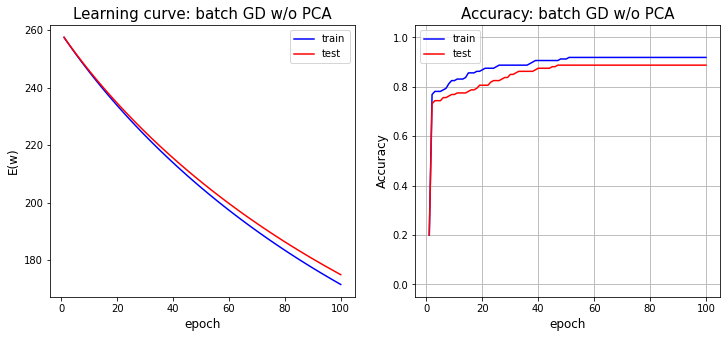

TYPE: SGD w/o PCA
Training accuracy: 0.91875
Test accuracy:     0.8875


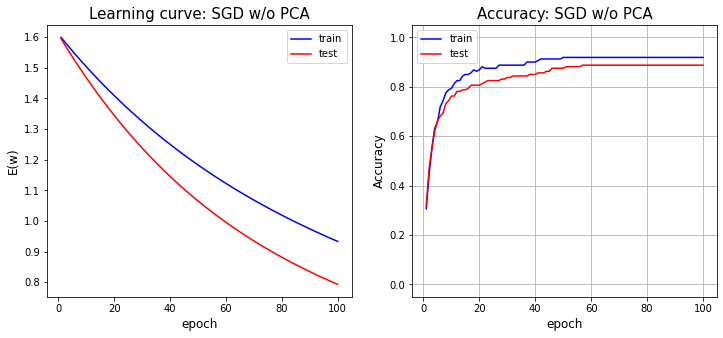

TYPE: mini-batch SGD w/o PCA
Training accuracy: 0.91875
Test accuracy:     0.8875


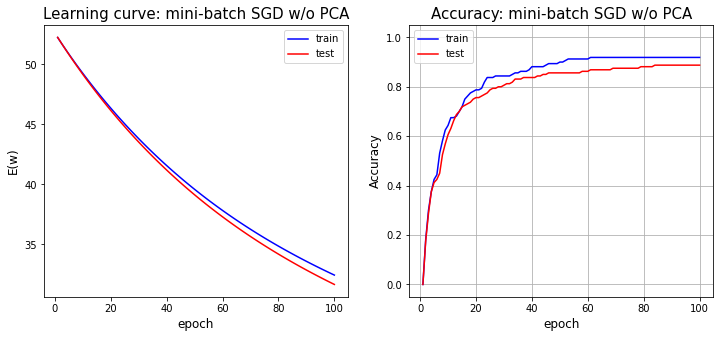

In [413]:
train_data_N = class_num * img_num / 2
case_l = ['batch GD','SGD','mini-batch SGD']
batch_size = [160, 1, 32] # each for batch GD, SGD and mini-batch SGD
iteration = []
for i in range(len(batch_size)):
  iteration.append(train_data_N / batch_size[i])

l_r = 0.00001 # learning rate
for N in range(len(case_l)):
  epoch = 0
  w = np.zeros([class_num, feature_num]) # 5*784
  err_list_train = []
  acc_list_train = []
  err_list_test = []
  acc_list_test = []
  while epoch < 100:
    train_accu_count = 0
    test_accu_count = 0
    for i in range(int(iteration[N])):
      # train
      tmp_train_x = train_x[i*batch_size[N]:(i+1)*batch_size[N], :]
      tmp_train_t = train_t[:, i*batch_size[N]:(i+1)*batch_size[N]]
      a_train = np.dot(w, tmp_train_x.T)
      y_train = np.exp(a_train) / np.sum(np.exp(a_train), axis=0)
      classify_y = np.argmax(y_train, axis=0)
      classify_t = np.argmax(tmp_train_t, axis=0)
      train_accu_count += np.count_nonzero((classify_y - classify_t) == 0)
      # test
      tmp_test_x = test_x[i*batch_size[N]:(i+1)*batch_size[N], :]
      tmp_test_t = test_t[:, i*batch_size[N]:(i+1)*batch_size[N]]
      a_test = np.dot(w, tmp_test_x.T)
      y_test = np.exp(a_test) / np.sum(np.exp(a_test), axis=0)
      classify_y = np.argmax(y_test, axis=0)
      classify_t = np.argmax(tmp_test_t, axis=0)
      test_accu_count += np.count_nonzero((classify_y - classify_t) == 0)
      # calculate weight
      w = w + l_r * np.dot((tmp_train_t - y_train), tmp_train_x)

    # train
    err = -np.sum(tmp_train_t * np.log(y_train))
    err_list_train.append(err)
    # classify_y = np.argmax(y_train, axis=0)
    # classify_t = np.argmax(tmp_train_t, axis=0)
    # accu = np.count_nonzero((classify_y - classify_t) == 0) / y_train.shape[1]
    accu = train_accu_count / train_data_N
    acc_list_train.append(accu)
    # test
    err = -np.sum(tmp_test_t * np.log(y_test))
    err_list_test.append(err)
    # classify_y = np.argmax(y_test, axis=0)
    # classify_t = np.argmax(tmp_test_t, axis=0)
    # accu = np.count_nonzero((classify_y - classify_t) == 0) / y_test.shape[1]
    accu = test_accu_count / train_data_N
    acc_list_test.append(accu)

    epoch += 1
  
  print('TYPE: ' + str(case_l[N]) + ' w/o PCA')
  print('Training accuracy: ' + str(acc_list_train[epoch-1]))
  print('Test accuracy:     ' + str(acc_list_test[epoch-1]))
  plt.figure(figsize=(12,5))
  plt.subplot(121)
  plt.title('Learning curve: ' + str(case_l[N]) + ' w/o PCA', fontsize = 15)
  plt.xlabel('epoch', fontsize = 12)
  plt.ylabel('E(w)', fontsize = 12)
  plt.plot(range(1, epoch+1), err_list_train, c='b', label='train')
  plt.plot(range(1, epoch+1), err_list_test, c='r', label='test')
  plt.legend(loc=0)
  plt.subplot(122)
  plt.title('Accuracy: ' + str(case_l[N]) + ' w/o PCA', fontsize = 15)
  plt.xlabel('epoch', fontsize = 12)
  plt.ylabel('Accuracy', fontsize = 12)
  plt.plot(range(1, epoch+1), acc_list_train, c='b', label='train')
  plt.plot(range(1, epoch+1), acc_list_test, c='r', label='test')
  plt.ylim(-0.05, 1.05)
  plt.legend(loc=0)
  plt.grid(True)
  plt.show()